In [56]:
import numpy as np
import pandas as pd
from joblib import load
from tensorflow.keras.models import load_model
from datetime import datetime
import matplotlib.pyplot as plt

In [57]:
# Load saved models and preprocessors to predict new data
X_preprocessor = load('model/X_preprocessor.joblib')
y_scaler = load('model/y_scaler.joblib')
model = load_model('model/best_model.keras')
X_train_orig = pd.read_csv('model/X_train.csv')
X_test_orig = pd.read_csv('model/X_test.csv')
y_train_orig = pd.read_csv('model/y_train.csv')
y_test_orig = pd.read_csv('model/y_test.csv')
history = load('model/model_history.joblib')

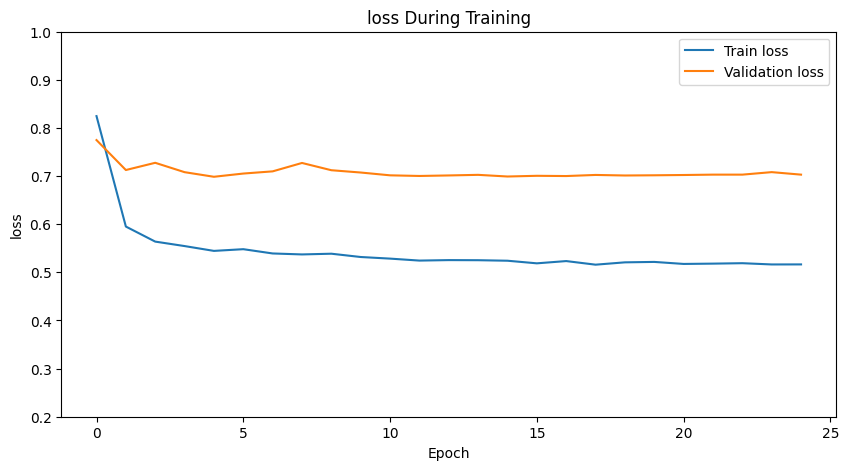

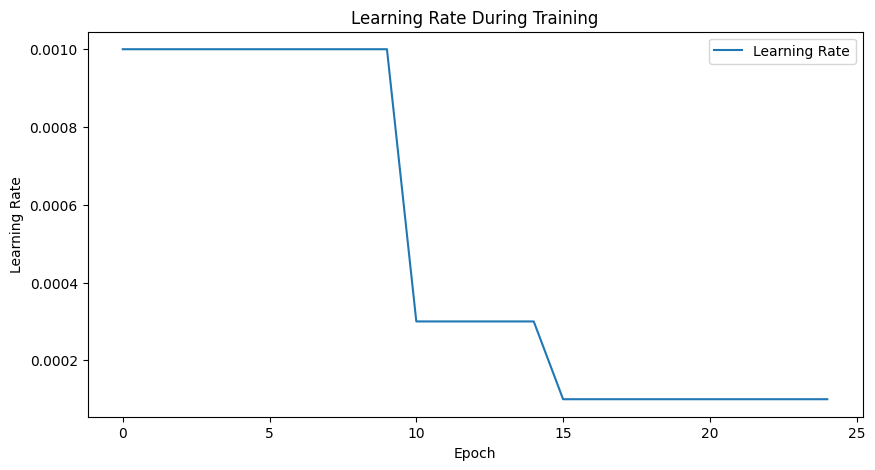

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Train loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('loss During Training')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.2, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate During Training')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

2/2 [==============================] - 0s 1ms/step


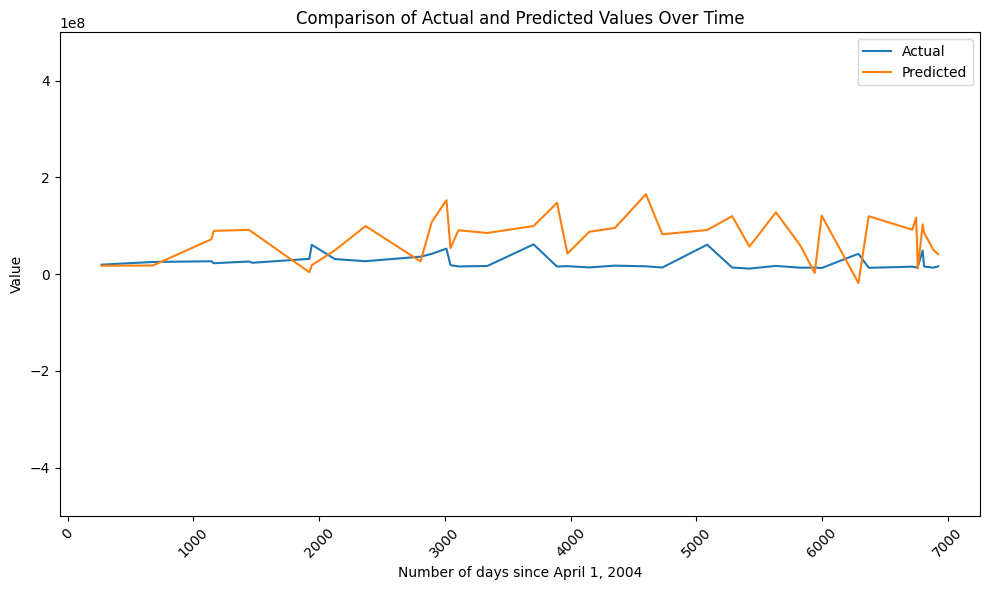

In [76]:
X_selected = X_test_orig[(X_test_orig['Electronic Category ID'] == 1) & (X_test_orig['Channel Type ID'] == 1) & (X_test_orig['Tax Category ID'] == 1)]
X_selected_processed = np.array(X_preprocessor.transform(X_selected).todense())
y_selected = y_test_orig.loc[X_selected.index]['Net Collections Amount']
yhat_selected = model.predict(X_selected_processed)
yhat_selected = y_scaler.inverse_transform(yhat_selected)
dates = X_selected['Record Date Discretized']
df_plot = pd.DataFrame({
    'Date': dates,
    'Actual': y_selected,
    'Predicted': yhat_selected.flatten()
})
df_plot_sorted = df_plot.sort_values(by='Date')
plt.figure(figsize=(10, 6))

plt.plot(df_plot_sorted['Date'], df_plot_sorted['Actual'], label='Actual')
plt.plot(df_plot_sorted['Date'], df_plot_sorted['Predicted'], label='Predicted')
plt.ylim([-5e8, 5e8])
plt.title('Comparison of Actual and Predicted Values Over Time')
plt.xlabel('Number of days since April 1, 2004')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
df = pd.read_csv('USGovtRevCollect_20041001_20231227.csv')
electronic_dict = pd.Series(df['Electronic Category ID'].values, index=df['Electronic Category Description']).to_dict()
channel_dict = pd.Series(df['Channel Type ID'].values, index=df['Channel Type Description']).to_dict()
tax_dict = pd.Series(df['Tax Category ID'].values, index=df['Tax Category Description']).to_dict()
base_date = df['Record Date'].min()

def evaluate(electronic_type, channel_type, tax_type, fiscal_year, fiscal_quarter, record_date):
    data = pd.DataFrame({})
    
    if electronic_type not in electronic_dict: return None
    else: data['Electronic Category ID'] = [electronic_dict[electronic_type]]
        
    if channel_type not in channel_dict: return None
    else: data['Channel Type ID'] = [channel_dict[channel_type]]
        
    if tax_type not in tax_dict: return None
    else: data['Tax Category ID'] = [tax_dict[tax_type]]
    
    data['Fiscal Year'] = [fiscal_year]
    data['Fiscal Quarter Number'] = [fiscal_quarter]
    
    try:
        date_obj = datetime.strptime(record_date, '%Y-%m-%d')
        data['Calendar Quarter Number'] = [(date_obj.month - 1) // 3 + 1]
        data['Calendar Month Number'] = [date_obj.month]
        basedate_obj = datetime.strptime(base_date, '%Y-%m-%d')
        data['Record Date Discretized'] = [(date_obj - basedate_obj).days]
    except ValueError:
        return None

    X = X_preprocessor.transform(data)
    X = np.array(X.todense())
    prediction = model.predict(X)
    prediction = y_scaler.inverse_transform(prediction)
    return prediction

In [45]:
# electronic_type = {
#     'Fully Electronic - All': 1,
#     'Fully Electronic - FS': 2,
#     'Electronic Settlement': 3,
#     'Non-Electronic': 4,
# }
# channel_type = {
#     'Over-the-Counter (OTC)': 1,
#     'Mail': 2,
#     'Internet': 3,
#     'Bank': 5,
#     'Other': 7,
# }
# tax_type = {
#     'Non-Tax': 1,
#     'IRS Non-Tax': 2,
#     'IRS Tax': 3
# }

result = evaluate(
    electronic_type='Fully Electronic - All',
    channel_type='Internet',
    tax_type='IRS Tax',
    fiscal_year=2025,
    fiscal_quarter=2,
    record_date='2025-2-20'
)
print('\nPredicted Net Collections Amount =', result[0][0])

1/1 [==============================] - 0s 15ms/step

Predicted Net Collections Amount = 17298844000.0
